# UCI SEMICOM dataset


After doing research about the dataset which can be found in the *word document* I will have put in the same folder as this analysis, I will now start to work on the dataset. I've taken a look into the dataset ( which you can also see in the sample ) and I know I have many columns with numerical variables. 

#### First we import all the important stuff and our dataset. 

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.feature_selection import VarianceThreshold

SemiCom = pd.read_csv("uci-secom.csv")
np.random.seed(0)

#### I will also add a function that makes sure the output is shown on full screen and not in a scrollable block.

comment: start from teh data set size

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
return false;
}

<IPython.core.display.Javascript object>

mentions something about the nature of these columns.

***
Here we can check our data really quick.
***

In [8]:
SemiCom.sample(5)

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
319,2008-08-20 01:42:00,2926.40,2421.45,2180.9666,998.4939,1.3990,100.0,106.3311,0.1216,1.3899,...,NaN,0.5036,0.0150,0.0035,2.9800,0.0262,0.0076,0.0022,29.1606,-1
1045,2008-09-23 22:25:00,2935.34,2551.27,2276.4556,2148.5397,1.2317,100.0,93.6778,0.1199,1.4132,...,NaN,0.4941,0.0178,0.0043,3.6018,0.0257,0.0174,0.0060,67.6124,-1
1323,2008-05-10 14:34:00,3023.56,2555.88,2205.2555,1412.7131,0.9785,100.0,95.2556,0.1216,1.5407,...,NaN,0.5018,0.0127,0.0034,2.5350,0.0230,0.0210,0.0053,91.4264,-1
579,2008-08-30 11:12:00,3042.36,2493.85,2124.8444,1180.2820,0.8465,100.0,100.7978,0.1257,1.3725,...,NaN,0.4970,0.0143,0.0031,2.8703,0.0182,0.0139,0.0039,76.6094,-1
414,2008-08-22 10:47:00,2965.48,2467.94,2178.6889,1657.3518,1.6603,100.0,100.8022,0.1229,1.5611,...,43.1616,0.5008,0.0109,0.0029,2.1758,0.0433,0.0187,0.0056,43.1616,-1


## Cleaning the data

***
Before I can start to work with this dataset i need to clean it. The information from the dataset said we did have missing values so lets start to work on those:

* I first want to see what I'm dealing with. So I can decide if i want to remove columns or add values.
***

In [9]:
#Let's check how many rows and columns we have in this dataset
totaldata = np.product(SemiCom.shape)
totaldata

927664

In [43]:
#Total amount of missimg data
missingdata = SemiCom.isnull().sum()
totalmissingdata = missingdata.sum()
totalmissingdata 

41951

***
Now one thing i want to do is check the percentage of the total missing values in this dataset.
***

In [11]:
(totalmissingdata/totaldata) * 100

4.522219251798065

In [47]:
#I wanted to check which colums had the most NaN values
aa = missingdata.sort_values(ascending=False)

<AxesSubplot: >

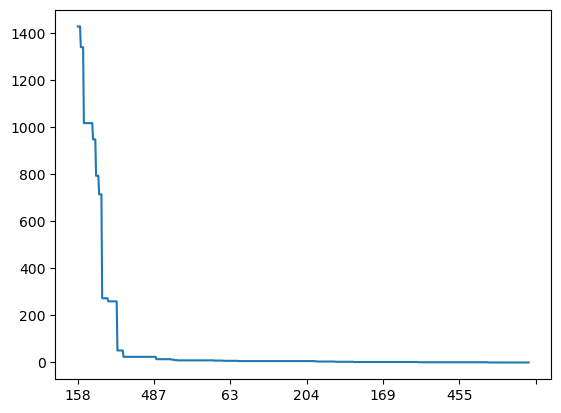

In [55]:
aa.plot()

comment: can you study where these missing values occur, are they co-occuring look like they are, can you seperate those rows, and analyze them separately. 
also you can check with the data description if there is any statemetn that may explain the missing values.

## Step 1 Cleaning: The threshold ###

***
As you can see not much of the data is missing so removing these wont have a big impact since the dataset has very many values. But, it is necessary to have a clean dataset so that our prediction is more accurate. So my plan is to make a threshold of 15%. When a column is missing more then 15% the collumn gets removed.
***

In [14]:
threshold = 0.15

columns_to_drop = missingdata[missingdata > threshold * len(SemiCom)].index
print(columns_to_drop)

Index(['72', '73', '85', '109', '110', '111', '112', '157', '158', '220',
       '244', '245', '246', '247', '292', '293', '345', '346', '358', '382',
       '383', '384', '385', '492', '516', '517', '518', '519', '546', '547',
       '548', '549', '550', '551', '552', '553', '554', '555', '556', '557',
       '562', '563', '564', '565', '566', '567', '568', '569', '578', '579',
       '580', '581'],
      dtype='object')


***
So here we can see all the columns that are above the threshold and need to be removed. My next step is dropping these columns and checking before and after if columns have been removed. I wanted to do this bit with the 'dropna()' function but this drops rows or columns based on missing values. It cannot be used to drop columns that you specify.
***

In [15]:
print(SemiCom.columns)

Index(['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '581', '582', '583', '584', '585', '586', '587', '588', '589',
       'Pass/Fail'],
      dtype='object', length=592)


In [16]:
SemiCom_dropped = SemiCom.drop(columns=columns_to_drop) #Dropping the columns that have more then 15% missing values

print(SemiCom_dropped.columns)

Index(['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '577', '582', '583', '584', '585', '586', '587', '588', '589',
       'Pass/Fail'],
      dtype='object', length=540)


***

As you can see our columns length has gone down from 592 to 540. Now we need look for other ways to remove columns that are useless because now we still have too many columns. 
After doing some research and asking ChatGPT how i could clean a dataset that has many numerical columns. I found the Variance threshold which means that you remove the columns that have mostly the same information. And because it's almost constantly the same it is not very usefull.

This is usefull for me because my dataset has many columns with probably the same information. Which wont provide any extra information for the model.

***

## Step 2: Variance threshold

*** 
First we have to make sure we have the types to a numerical type. 
***

In [17]:
#had a small error about the time not being able to covert to float and because time is not usefull to the model, I removed it

SemiCom_dropped= SemiCom_dropped.drop(['Time'], axis=1)


In [18]:
print(SemiCom_dropped.dtypes)

0            float64
1            float64
2            float64
3            float64
4            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 539, dtype: object


***
I chose a variance of 0.05 because in my opinion if its beneath 0.05 it is a very minimal change and wont affect the module.
***

In [19]:

thresholder = VarianceThreshold(threshold=0.05)

X_high_variance = thresholder.fit_transform(SemiCom_dropped)
#put the remaining columns in a list
selected_features = SemiCom_dropped.columns[thresholder.get_support()].tolist()
SemiCom_filtered = SemiCom_dropped[selected_features]

SemiCom_filtered.columns

Index(['0', '1', '2', '3', '4', '6', '12', '14', '15', '16',
       ...
       '570', '571', '572', '573', '574', '576', '577', '585', '589',
       'Pass/Fail'],
      dtype='object', length=251)

***
Yep! that was a good one. We just cut our columns in half from 540 to 251.

***

## Step 3: Correlation Matrix

***
With this method we want to reduce highly correlated columns. The reason behind this is that we probably have columns that have similar information. This will help minimalize the dataset and gives us more relevant information.

I will be using a threshold of 0.8 which means that any columns with a correlation above 0.8 will be added to the list of columns that will be removed. The "For" loop compares all the columns with eachother and if the columns are highly correlated they will be put into the variable "i" and "j". all the columns in "j" will be removed.
***

In [20]:

correlation_matrix = SemiCom_filtered.corr().abs()
threshold = 0.8  #Remove columns with a correlation above 0.8

#Find columns with high correlation
highly_correlated_cols = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_cols.append(colname_j)

#Dropping highly correlated columns
SemiCom_correlated = SemiCom_filtered.drop(columns=highly_correlated_cols)
print(highly_correlated_cols)


['140', '275', '413', '148', '152', '154', '283', '287', '289', '420', '421', '425', '427', '36', '60', '46', '50', '66', '65', '70', '196', '197', '199', '204', '205', '207', '332', '333', '335', '336', '340', '341', '343', '469', '477', '479', '252', '390', '524', '270', '408', '271', '409', '272', '410', '273', '411', '274', '412', '275', '413', '277', '415', '152', '154', '283', '287', '289', '420', '421', '425', '427', '285', '286', '424', '154', '283', '287', '289', '420', '421', '425', '427', '283', '287', '289', '420', '421', '425', '427', '290', '428', '164', '294', '430', '295', '431', '296', '297', '165', '294', '430', '431', '434', '435', '436', '294', '430', '431', '434', '435', '436', '301', '437', '448', '316', '452', '453', '318', '454', '319', '455', '187', '321', '323', '457', '459', '321', '323', '457', '459', '324', '467', '197', '199', '203', '204', '205', '207', '332', '333', '335', '336', '340', '341', '343', '469', '471', '477', '479', '199', '204', '205', '207'

In [21]:
SemiCom_correlated.columns

Index(['0', '1', '2', '3', '4', '6', '12', '14', '15', '16',
       ...
       '539', '545', '561', '570', '571', '572', '573', '585', '589',
       'Pass/Fail'],
      dtype='object', length=138)

***
Now we're getting somewhere. We went from 251 to 138. I think this is pretty decent but I'm not completely happy with the amount of columns left. So I'm going to do some more research and find other ways to minimalize this number.
***

## Step 4: Fill Missing values

***
One of the last Cleaning steps is filling the remaining missing values. I'm doing this by filling the missing value with the mean or median. But which one is the best option for this dataset? When I searched online I found out that mean is often used when the distribution is pretty symmetric in this case median can also be used. The difference wont be big. When the distribution is skewed the mean is not useful. The median is less sensitive to outliers.

So our first step is seeing what distribution this dataset has.
***

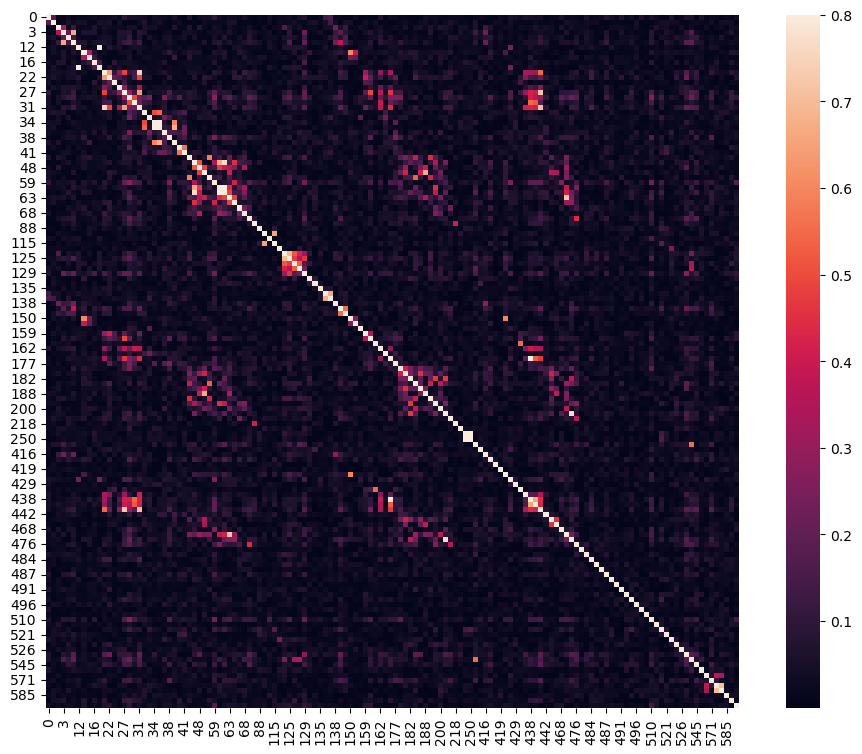

In [56]:
correlationmat = SemiCom_correlated.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(np.abs(correlationmat), vmax=.8, square=True);


is target here or not. make it clear!

[optional] Try out Hierarchical clustering and find similar columns, maybe also useful for missing values

***
Let's look at the skewness of our dataset.
***

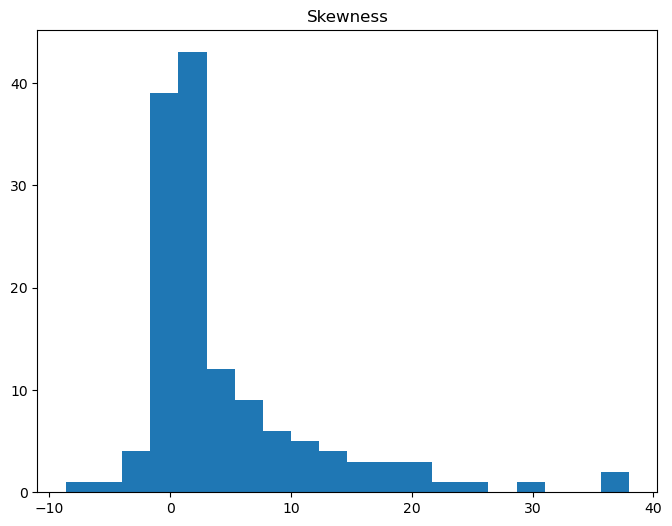

In [23]:
skewness = SemiCom_correlated.skew()

plt.figure(figsize=(8, 6))
plt.hist(skewness, bins=20)
plt.title('Skewness')
plt.show()

the tail values are important to identify , maybe you want to remove these or note any pattern, later if you build a model, you can check if it works on these points

***
So from the graph above we can mke the conclusion that we're dealing with a skewed distribution. And from our research we now know we need to use the "Mean" to fill/Impude the remaining missing values.
***

In [24]:
missingvalues = SemiCom_correlated.isnull().sum()
print(missingvalues.sum())
print(missingvalues.shape)

886
(138,)


In [25]:
SemiCom_correlated = SemiCom_correlated.fillna(SemiCom_correlated.mean())
missingdata = SemiCom_correlated.isnull().sum()
totalmissingdata = missingdata.sum()
print(totalmissingdata)
print(missingdata.shape)

0
(138,)


build a base line early, 

## Step 5: Handling outliers - Is this a good method for my dataset?

***

To clean my dataset some more my next step was to get rid of the outliers. But when i started removing the outliers 1/3 of my dataset went away. So I'm not too sure about handling the outliers

optional: after modeling you can look into regions where the error is large, by selecting points with large prediction error, and compare the statisitcs of the features for those points with the the rest of the points. for example side to side bar plots for each feature. make a plot of the difference of the mean or median

beacuae you have too many features, maybe you can group columns via hierarchical clustering and then analyze in the group.

consider the model you want to use, does this model need scaling?


calculate the correlation of all features with the target and make a bar plot, and find highly occrelating features, for those make a scatter plot. 
calculate the mutual information  of all features with the target and make a bar plot, and find highly occrelating features, for those make a scatter plot. 

goal is to predict ==. strategy is what is informaing us about the target

compare performance as you inisitall planned. histograms.
compare the count of each class, establish if it is imbalanced.

<AxesSubplot: >

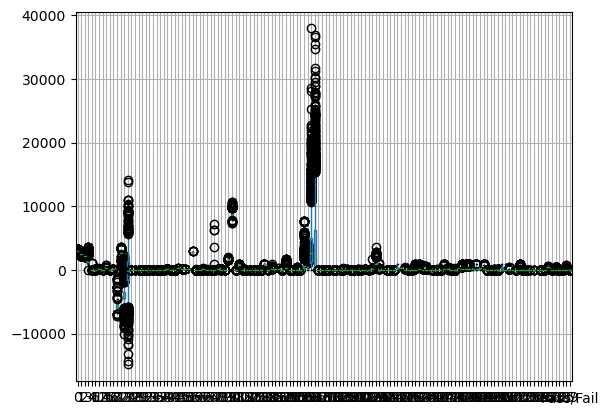

In [26]:
SemiCom_correlated.boxplot()

In [27]:
threshold_percentile = 99  # Consider values above the 95th percentile as outliers

# Iterate over each column
for column in SemiCom_correlated.columns:
    # Calculate the threshold value for the column
    threshold = np.percentile(SemiCom_correlated[column], threshold_percentile)

    # Identify outliers and replace them with NaNs
    SemiCom_correlated.loc[SemiCom_correlated[column] > threshold, column] = np.nan

# Drop rows with any NaN values
df_cleaned = SemiCom_correlated.dropna()


<AxesSubplot: >

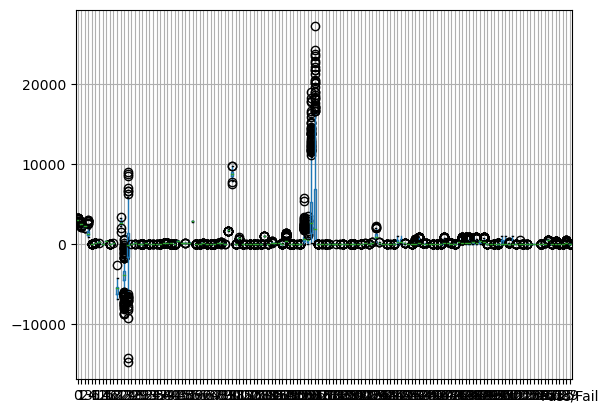

In [28]:
df_cleaned.boxplot()

In [29]:
print(df_cleaned.shape)
print(SemiCom_correlated.shape)


(511, 138)
(1567, 138)


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer


# Split the dataset into features (X) and target variable (y)
X = SemiCom_correlated.drop(columns=['Pass/Fail'])
y = SemiCom_correlated['Pass/Fail']
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create a logistic regression model (you can use any other model of your choice)
model = LogisticRegression()

# Fit the model on the original dataset (with imputed missing values)
model.fit(X_train_imputed, y_train)

# Make predictions on the original test set (with imputed missing values)
y_pred_original = model.predict(X_test_imputed)


print("Accuracy: ", model.score(X_test,y_test)*100)



/Users/alex/opt/anaconda3/envs/DataAnalytics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alex/opt/anaconda3/envs/DataAnalytics/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').